# **チュートリアルを参考にしたデータハンドリングによって簡単な回帰を試してみる**

### **必要な関数・ライブラリ**

In [1]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import os
import sys
from new_MLP import MLP

%matplotlib inline

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [4]:
def add_hour_month(input_data):
    '''
    時間や月のデータを加える
    '''
    input_data['hour'] = input_data['datetime'].map(lambda x: int(x.hour))
    input_data['minute'] = input_data['datetime'].map(lambda x: int(x.minute))
    input_data['month'] = input_data['datetime'].map(lambda x: int(x.month))
    input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
    input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
    input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
    input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
    input_data = input_data.drop(['hour', 'minute', 'month'], axis=1)
    return input_data

In [5]:
def get_30(tmp_data):
    '''
    必要なカラムだけ拾ってきて30分ごのデータに整形
    '''
    tmp_data = tmp_data[["datetime", "pr", "max_ws", "ave_ws", "max_tp", "min_tp", "sl"]]
    
    # 欠損値を一つ前の値で置換/output_data
    tmp_data = tmp_data.fillna(method='bfill')
    tmp_30 = tmp_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

    # datetimeのカラムを復活させる
    tmp_30['datetime'] = tmp_30.index
    tmp_30.index = np.arange(len(tmp_30))
    tmp_30.head()
    return tmp_30

In [6]:
def add_time_data(input_data, key="datetime"):
    '''
    時間や月のデータを加える
    '''
    input_data['month'] = input_data[key].map(lambda x: int(x.month))
    input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
    input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
    input_data['hour'] = input_data[key].map(lambda x: int(x.month))
    input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
    input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
    input_data = input_data.drop(['month', 'hour'], axis=1)
    return input_data

In [7]:
def normalize_array(x):
    '''
    min, max, min-max正規化を行なった配列(np.array)を返す
    '''
    x = np.array(x)
    x_min = x.min()
    x_max = x.max()
    normalized = (x - x_min) / (x_max - x_min) 
    return x_min, x_max, normalized

In [8]:
def denormalize_array(normalized_x, x_min, x_max):
    '''
    正規化前のmin, maxを用いて元のスケールに戻す
    '''
    normalized_x = np.array(normalized_x)
    denormalize_array = (normalized_x) * (x_max - x_min) + x_min
    return denormalize_array

In [9]:
def drop_nan(X, Y):
    '''
    正解データがnanであるデータの組を削除
    '''
    mask = np.isnan(Y)
    X = X[~mask]
    Y = Y[~mask]
    return X, Y

In [10]:
def calc_mae(X, Y):
    '''
    X, Yがメモリを食いすぎるのでfor文で計算
    '''
    mse = 0
    for i in range(len(X)):
        mse += np.abs(X[i]- Y[i])
    return mse/len(X)

In [11]:
def scaling_output(output_30):
    '''
    直近2015年の総発電量に合わせて他の年の初で量も合わせる関数
    '''
    output_30['year'] = output_30['datetime'].map(lambda x : x.year)
    y_output = output_30.groupby(['year'], as_index=False).sum()
    sum_2012 = y_output["SOLA0"+str(target_place)][0]
    sum_2013 = y_output["SOLA0"+str(target_place)][1]
    sum_2014 = y_output["SOLA0"+str(target_place)][2]
    sum_2015 = y_output["SOLA0"+str(target_place)][3]
    scaled_2012 = np.array(output_30[output_30['year'] == 2012]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2012))
    scaled_2013 = np.array(output_30[output_30['year'] == 2013]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2013))
    scaled_2014 = np.array(output_30[output_30['year'] == 2014]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2014))
    scaled_2015 = np.array(output_30[output_30['year'] == 2015]["SOLA0"+str(target_place)])
    tmp = np.r_[scaled_2012, scaled_2013, scaled_2014, scaled_2015]
    output_30["SOLA0"+str(target_place)] = tmp
    
    return output_30

In [12]:
def wv_to_sin(x):
    '''
    漢字になってる風向データをsinになおす
    '''
    if x == "北":
        return -1.0
    elif x == "北西":
        return -0.5
    elif x == "西":
        return 0.0
    elif x == "南西":
        return 0.5
    elif x == "南":
        return 1.0
    elif x == "南東":
        return 0.5
    elif x == "東":
        return 0
    else:
        return -0.5

In [13]:
def wv_to_cos(x):
    '''
    漢字になってる風向データをcosになおす
    '''
    
    if x == "北":
        return 0.0
    elif x == "北西":
        return 0.5
    elif x == "西":
        return 1.0
    elif x == "南西":
        return 0.5
    elif x == "南":
        return 0.0
    elif x == "南東":
        return -0.5
    elif x == "東":
        return -1.0
    else:
        return -0.5

In [14]:
def extract_hours(output_30):
    '''
    決まった時間帯のみを予測するための関数
    '''
    output_30[ "hour"] = output_30["datetime"].map(lambda x : x.hour)
    output_30 = output_30[output_30["hour"] > 6]
    output_30 = output_30[output_30["hour"] < 20]
    output_30 = output_30.drop(["hour"], axis=1)
    return output_30

In [15]:
def minus_to_zero(x):
    if x < 0:
        return 0
    else:
        return x

### **データの準備**

In [16]:
target_place = 3

In [17]:
# 発電量データ
output_30 = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
output_30['datetime'] = output_30['datetime'].map(lambda x : pd.to_datetime(x))
output_30 = output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

In [18]:
# 天気予報のデータを実は今まで使ってなかった
if target_place == 1 or target_place == 2:
    fc_data = pd.read_csv('data/raw_data/forecast_kanagawa.tsv', delimiter = '\t')
    fc_data['date'] = fc_data['date'].map(lambda x : pd.to_datetime(x))
elif target_place == 3:
    fc_data = pd.read_csv('data/raw_data/forecast_yamanashi.tsv', delimiter = '\t')
    fc_data['date'] = fc_data['date'].map(lambda x : pd.to_datetime(x))
else:
    raise ValueError("invalid input target_place")

In [19]:
fc_data.columns

Index(['date', 'weather', 'weather_detail', 'wind', 'wave', 'pc_00-06',
       'pc_06-12', 'pc_12-18', 'pc_18-24', 'we_00-03', 'we_03-06', 'we_06-09',
       'we_09-12', 'we_12-15', 'we_15-18', 'we_18-21', 'we_21-24', 'wv_00-03',
       'wv_03-06', 'wv_06-09', 'wv_09-12', 'wv_12-15', 'wv_15-18', 'wv_18-21',
       'wv_21-24', 'wc_00-03', 'wc_03-06', 'wc_06-09', 'wc_09-12', 'wc_12-15',
       'wc_15-18', 'wc_18-21', 'wc_21-24', 'min_tp', 'max_tp', 'tp_00-03',
       'tp_03-06', 'tp_06-09', 'tp_09-12', 'tp_12-15', 'tp_15-18', 'tp_18-21',
       'tp_21-24'],
      dtype='object')

In [20]:
# 各データ期間のタイムスタンプを作成
# 学習＋評価期間：30分間隔
total_rng = pd.date_range("201201010000", "201703312330", freq="30T")

In [21]:
input_df= pd.DataFrame()
input_df["datetime"] = total_rng

In [22]:
# 3時間毎天気予報の追加
fc_weather = fc_data.loc[:,fc_data.columns.str.startswith("we_")]
fc_weather = fc_weather.values.flatten()
fc_weather = np.repeat(fc_weather, 6)
input_df["weather"] = fc_weather

# 3時間毎気温の追加
fc_weather = fc_data.loc[:,fc_data.columns.str.startswith("tp_")]
fc_weather = fc_weather.values.flatten()
fc_weather = np.repeat(fc_weather, 6)
input_df["tp"] = fc_weather

# 3時間毎風向の追加
fc_weather = fc_data.loc[:,fc_data.columns.str.startswith("wv_")]
fc_weather = fc_weather.values.flatten()
fc_weather = np.repeat(fc_weather, 6)
input_df["wv"] = fc_weather
input_df["wv_cos"] = input_df["wv"].map(lambda x : wv_to_cos(x))
input_df["wv_sin"] = input_df["wv"].map(lambda x : wv_to_sin(x))
input_df = input_df.drop(["wv"], axis=1)

# 3時間毎風速の追加
fc_weather = fc_data.loc[:,fc_data.columns.str.startswith("wc_")]
fc_weather = fc_weather.values.flatten()
fc_weather = np.repeat(fc_weather, 6)
input_df["wc"] = fc_weather

# 6時間毎降水確率の追加
fc_weather = fc_data.loc[:,fc_data.columns.str.startswith("pc_")]
fc_weather = fc_weather.values.flatten()
fc_weather = np.repeat(fc_weather, 12)
input_df["pc"] = fc_weather

In [23]:
input_df['month'] = input_df['datetime'].map(lambda x: str(x.month))
input_df['hour'] = input_df['datetime'].map(lambda x : str(x.hour))

In [24]:
# sincosのダミー変数は使わない
input_df = pd.get_dummies(input_df)

In [25]:
input_df.head()

,datetime,tp,wv_cos,wv_sin,wc,pc,weather_くもり,weather_晴れ,weather_雨,weather_雪,...,hour_21,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9
0,2012-01-01 00:00:00,1,0.5,0.5,2,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2012-01-01 00:30:00,1,0.5,0.5,2,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2012-01-01 01:00:00,1,0.5,0.5,2,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2012-01-01 01:30:00,1,0.5,0.5,2,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2012-01-01 02:00:00,1,0.5,0.5,2,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# モデル構築のためにデータを分割する
wfc_data = input_df

# 学習に必要なデータ
# 前日の気象予報のデータで翌日の0:00 ~ 23:30を予測する
train_x_s_idx = wfc_data[wfc_data['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
train_x_e_idx = wfc_data[wfc_data['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]
train_y_s_idx = output_30[output_30['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
train_y_e_idx = output_30[output_30['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]

# 決まった時間帯のみを予測する
# output_kwh = output_30[train_y_s_idx:train_y_e_idx+1]
# output_kwh = extract_hours(output_kwh)["SOLA0"+str(target_place)]
# input_data = wfc_data[train_x_s_idx:train_x_e_idx+1]
# input_data = extract_hours(input_data).drop(["datetime"], axis=1)

output_kwh = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
input_data = wfc_data.drop(["datetime"], axis=1)[train_x_s_idx:train_x_e_idx+1]

# 予測に必要なデータ
# 前日の00:00 ~ 20:00のデータで翌日の0:00 ~ 23:30を予測する
test_x_s_idx = wfc_data[wfc_data["datetime"] == pd.to_datetime('2016-01-01 00:00')].index[0]
test_x_e_idx = wfc_data[wfc_data["datetime"] == pd.to_datetime('2017-3-31 23:30')].index[0]

# 決まった時間のみを予測する
# test_input_data = wfc_data[test_x_s_idx:test_x_e_idx+1]
# test_input_data = extract_hours(test_input_data).drop(["datetime"], axis=1)

test_input_data = wfc_data.drop(["datetime"], axis=1)[test_x_s_idx:test_x_e_idx+1]

In [27]:
# min-max正規化しておく
normalized_input = (input_data - input_data.min()) / (input_data.max() - input_data.min())
normalized_input = normalized_input.dropna(axis=1)
normalized_input = np.array(normalized_input)
normalized_kwh = (output_kwh) /( output_kwh.max())
normalized_kwh = np.array(normalized_kwh)

input_list = normalized_input
kwh_list =normalized_kwh

X, Y = drop_nan(input_list, kwh_list)

# testデータの入力を用意
normalized_test_input = (test_input_data - test_input_data.min()) / (test_input_data.max() - test_input_data.min())
normalized_test_input = normalized_test_input.dropna(axis=1)
normalized_test_input = np.array(normalized_test_input)

X_test = normalized_test_input

# denormalize用
kwh_max = float(output_kwh.max())
kwh_min = 0

In [28]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

### **とりあえず発電しない時間帯を除かない状態でやってます**

### **線形回帰**

In [29]:
from sklearn import linear_model

In [30]:
lin_model = linear_model.LinearRegression()
lin_model.fit(X_train, Y_train)

Y_train_pred = lin_model.predict(X_train)
Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

Y_val_pred = lin_model.predict(X_val)
Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)

print("train_mae : ", np.abs(Y_train_pred - Y_train_true).mean())
print("test_mae : ", np.abs(Y_val_pred - Y_val_true).mean())

train_mae :  378.975672816
test_mae :  381.854633349


/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [31]:
Y_test_pred = lin_model.predict(X_test)
Y_test_pred = denormalize_array(Y_test_pred, kwh_min, kwh_max)

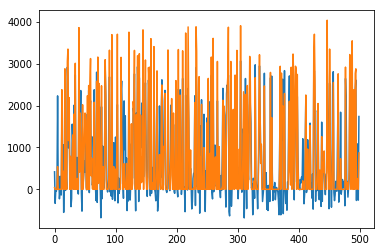

In [32]:
plt.plot(Y_val_pred[0:500])
plt.plot(Y_val_true[0:500])

### **マイナスを0にすれば幾分スコアは上がりそうだが...**
**L1, L2ノルムを加えて正則化してどうこうの問題じゃないような気がする**

### **PLS(なんか動かないです)**

In [33]:
# from sklearn.cross_decomposition import PLSRegression
# from sklearn.model_selection import KFold

In [34]:
'''
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    pls = PLSRegression(n_components = 3)
    pls.fit(X_train, Y_train)
    Y_train_pred = denormalize_array(pls.predict(X_train), kwh_min, kwh_max)
    Y_val_pred = denormalize_array(pls.predict(X_val), kwh_min, kwh_max)
    t_maes.append(np.abs(Y_train_pred - denormalize_array(Y_train, kwh_min, kwh_max)).mean())
    v_maes.append(np.abs(Y_val_pred - denormalize_array(Y_val, kwh_min, kwh_max)).mean())
'''
print()

### **random forest**

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
# 最適な深さを決める

train_maes = []
val_maes = []
n = 30
n_start = 10
for i in range(n):
    rf = RandomForestRegressor(n_estimators = 10, max_depth = i+n_start)
    rf.fit(X_train, Y_train)
    
    Y_train_pred = rf.predict(X_train)
    Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
    Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)
    
    Y_val_pred = rf.predict(X_val)
    Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
    Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)
    
    train_maes.append(np.abs(Y_train_pred - Y_train_true).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val_true).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

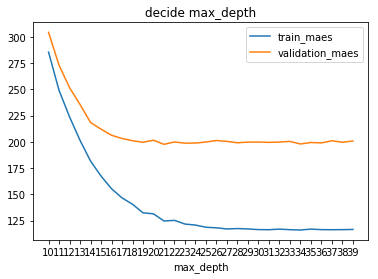

In [37]:
plt.plot(train_maes, label="train_maes")
plt.plot(val_maes, label="validation_maes")
plt.xticks(np.arange(n), np.arange(n)+n_start)
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

### **17で十分なように見えるが5foldでやってみるとそうでもない**

In [39]:
rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth)

rf.fit(X_train, Y_train)

Y_train_pred = rf.predict(X_train)
Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

Y_val_pred = rf.predict(X_val)
Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)

print("train_mae : ", np.abs(Y_train_pred - Y_train_true).mean())
print("val_mae : ", np.abs(Y_val_pred - Y_val_true).mean())

train_mae :  114.853537153
val_mae :  198.586205751


In [41]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    
    rf = RandomForestRegressor(n_estimators = 10, max_depth = 17)
    rf.fit(X_train, Y_train)
    
    Y_train_pred = rf.predict(X_train)
    Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
    Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)
    
    Y_val_pred = rf.predict(X_val)
    Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
    Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)
    
    t_maes.append(np.abs(Y_train_pred - Y_train_true).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val_true).mean())

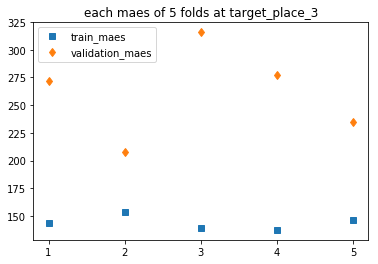

261.473971479


In [42]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()
print(np.array(v_maes).mean())

In [43]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    
    rf = RandomForestRegressor(n_estimators = 10, max_depth = 30)
    rf.fit(X_train, Y_train)
    
    Y_train_pred = rf.predict(X_train)
    Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
    Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)
    
    Y_val_pred = rf.predict(X_val)
    Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
    Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)
    
    t_maes.append(np.abs(Y_train_pred - Y_train_true).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val_true).mean())

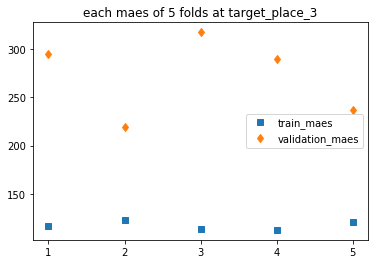

271.828599572


In [44]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()
print(np.array(v_maes).mean())

In [45]:
Y_test_pred = rf.predict(X_test)
Y_test_pred = denormalize_array(Y_test_pred, kwh_min, kwh_max)

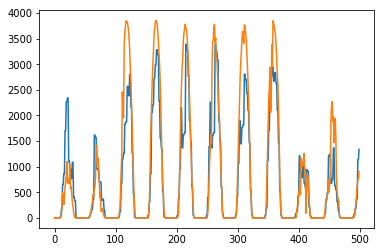

In [46]:
plt.plot(Y_val_pred[0:500])
plt.plot(Y_val_true[0:500])

### **最適なmax_depthがtrain test split の分かれ方に依存しがち**

### **KNN**

In [47]:
from sklearn.neighbors import KNeighborsRegressor

In [48]:
# 最適なkを見つける
# 実行に時間がかかります
train_maes = []
val_maes = []
for i in range(10):
    k = i+1
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, Y_train)

    Y_train_pred = knn.predict(X_train)
    Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
    Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

    Y_val_pred = knn.predict(X_val)
    Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
    Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)
    train_maes.append(np.abs(Y_train_pred - Y_train_true).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val_true).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train_true).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val_true).mean())

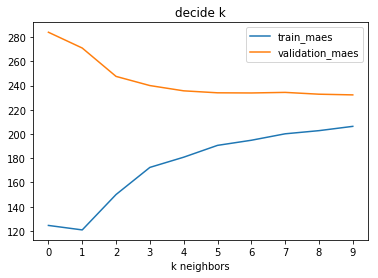

In [49]:
plt.plot(train_maes, label="train_maes")
plt.plot(val_maes, label="validation_maes")
plt.xticks(np.arange(10), np.arange(10))
plt.xlabel("k neighbors")
plt.title("decide k")
plt.legend()

In [50]:
k = 4
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train, Y_train)

Y_train_pred = knn.predict(X_train)
Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

Y_val_pred = knn.predict(X_val)
Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)

print("train_mae : ", np.abs(Y_train_pred - Y_train_true).mean())
print("val_mae : ", np.abs(Y_val_pred - Y_val_true).mean())

train_mae :  172.451748841
val_mae :  239.972629839


In [51]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
k = 4
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, Y_train)
    
    Y_train_pred = knn.predict(X_train)
    Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
    Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)
    
    Y_val_pred = knn.predict(X_val)
    Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
    Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)
    
    t_maes.append(np.abs(Y_train_pred - Y_train_true).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val_true).mean())

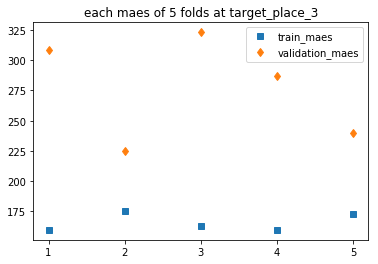

276.789402139


In [52]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()
print(np.array(v_maes).mean())

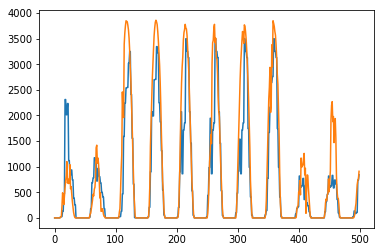

In [53]:
plt.plot(Y_val_pred[0:500])
plt.plot(Y_val_true[0:500])

### **過去の検索に過ぎないから予測と言えるか...**
**blending の時に入れると安定するかも？？**

### **SVR**

In [54]:
from sklearn.svm import SVR

In [55]:
C = 0.2
epsilon = 0.001
svr = SVR(C=C, epsilon=epsilon)
svr.fit(X_train, Y_train) 

Y_train_pred = svr.predict(X_train)
Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

Y_val_pred = svr.predict(X_val)
Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)

print("train_mae : ", np.abs(Y_train_pred - Y_train_true).mean())
print("val_mae : ", np.abs(Y_val_pred - Y_val_true).mean())

train_mae :  273.342238476
val_mae :  249.211243348


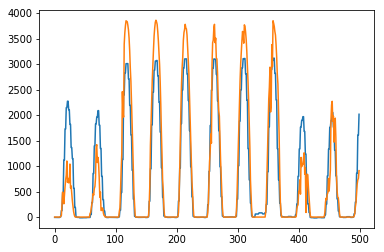

In [56]:
plt.plot(Y_val_pred[0:500])
plt.plot(Y_val_true[0:500])

In [57]:
C = 0.1
epsilon = 0.001
svr = SVR(C=C, epsilon=epsilon, kernel="rbf")
svr.fit(X_train, Y_train) 

Y_train_pred = svr.predict(X_train)
Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

Y_val_pred = svr.predict(X_val)
Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)

print("train_mae : ", np.abs(Y_train_pred - Y_train_true).mean())
print("val_mae : ", np.abs(Y_val_pred - Y_val_true).mean())

train_mae :  292.859181267
val_mae :  267.223127591


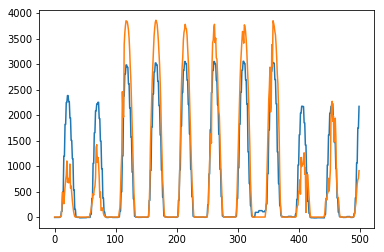

In [58]:
plt.plot(Y_val_pred[0:500])
plt.plot(Y_val_true[0:500])

In [59]:
C = 0.1
epsilon = 0.001
svr = SVR(C=C, epsilon=epsilon, kernel="poly", degree=3)
svr.fit(X_train, Y_train) 

Y_train_pred = svr.predict(X_train)
Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

Y_val_pred = svr.predict(X_val)
Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)

print("train_mae : ", np.abs(Y_train_pred - Y_train_true).mean())
print("val_mae : ", np.abs(Y_val_pred - Y_val_true).mean())

train_mae :  669.616521403
val_mae :  560.938476063


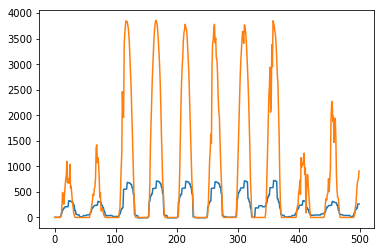

In [60]:
plt.plot(Y_val_pred[0:500])
plt.plot(Y_val_true[0:500])

### **パラメータチューニングすれば可能性を感じなくもない**
**train, valの分かれ方が偶然簡単だった説はある**

### ** MLP **

In [61]:
# MLPに突っ込むための準備をする

# min-max正規化しておく
normalized_input = (input_data - input_data.min()) / (input_data.max() - input_data.min())
normalized_input = normalized_input.dropna(axis =1)
normalized_input = np.array(normalized_input)
normalized_kwh = (output_kwh - 0) /(output_kwh.max() - 0)
normalized_kwh = np.array(normalized_kwh)

# input_dataに関しては正規化すればそのまま使える
input_list = normalized_input
kwh_list = normalized_kwh

# outputがnanであれば取り除く
filtered_input_list, filtered_kwh_list = drop_nan(input_list, kwh_list)

# testデータの入力を用意
normalized_test_input = (test_input_data - input_data.min()) / (input_data.max() - input_data.min())
normalized_test_input = normalized_test_input.dropna(axis=1)
normalized_test_input = np.array(normalized_test_input)

test_input_list = normalized_test_input

# denormalize用
kwh_max = float(output_kwh.max())
kwh_min = 0

# MLPに突っ込むためにデータを整形
X = np.array(filtered_input_list).reshape(filtered_input_list.shape[0], filtered_input_list.shape[1])
all_X = np.array(input_list).reshape(input_list.shape[0], input_list.shape[1])
KWH = np.array(filtered_kwh_list).reshape(filtered_kwh_list.shape[0],1)
X_predict = np.array(test_input_list).reshape(test_input_list.shape[0], test_input_list.shape[1])

In [62]:
epochs = 1000
hidden_size = 100
batch_size = 100
activation = "sigmoid"
model_name = "test"
batch_normalization = False
try:
    os.mkdir('./data/model/'+model_name)
    print("make save directory")
except :
    print("directory already exists")

print(model_name)

directory already exists
test


In [63]:
X_train, X_val, Y_train, Y_val = train_test_split(X, KWH, test_size=0.33)

In [64]:
mlp_model = MLP(X_train, Y_train, X_val, Y_val, epochs = epochs, hidden_size = hidden_size, batch_size = batch_size, model_name = model_name, activation = activation, batch_normalization = batch_normalization)

In [65]:
validation_losses = mlp_model.train()

train#0, validation loss: 6.466643e-02
train#20, validation loss: 6.944202e-02
train#40, validation loss: 3.521584e-02
train#60, validation loss: 1.764732e-02
train#80, validation loss: 1.524796e-02
train#100, validation loss: 1.383821e-02
train#120, validation loss: 1.319848e-02
train#140, validation loss: 1.323613e-02
train#160, validation loss: 1.391368e-02
do early stopping


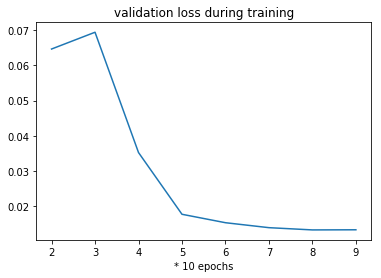

In [66]:
length = len(validation_losses[:])
plt.plot(validation_losses[:])
plt.xticks(np.arange(length), (np.arange(length)+2))
plt.title("validation loss during training")
plt.xlabel("* 10 epochs")

print()

training mae : [ 315.06033325]


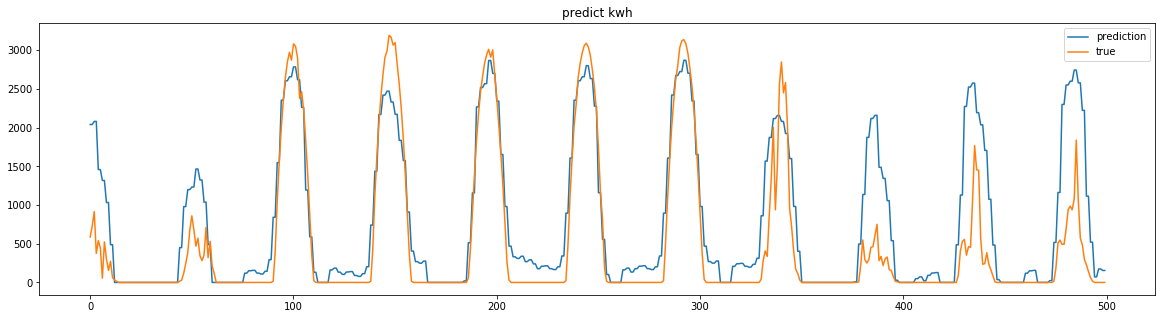

In [67]:
predictions = mlp_model.predict(X)[0]
processed_prediction = denormalize_array(predictions, kwh_min, kwh_max)
# 予測値のマイナスがでかすぎたのでマイナスを0にしている
processed_prediction[np.where(processed_prediction < 0)] = 0

true = filtered_kwh_list
true = denormalize_array(true, kwh_min, kwh_max)

plt.figure(figsize=(20, 5))
plt.plot(processed_prediction[500:1000], label = "prediction")
plt.plot(true[500:1000], label = "true")
plt.legend()
plt.title("predict kwh")

print('training mae :', calc_mae(processed_prediction, true))

In [68]:
validation = mlp_model.predict(mlp_model.X_val)[0]
processed_validation = denormalize_array(validation, kwh_min, kwh_max)
processed_validation[np.where(processed_validation < 0)] = 0

val = denormalize_array(mlp_model.Y_val, kwh_min, kwh_max)

print('validation mae :', calc_mae(processed_validation, val))

validation mae : [ 315.49248057]


###  **別のipynbのmlpとはデータの読み込ませ方が違う事に注意**